# Using code from John Slattery to generate some data for test

In [1]:
# functions from John Slattery's work

import numpy as np


def linear_ramp(t, t0=0.0, dt=1.0, y0=0.0, dy=1.0, GS_slope = 0.0, GIS_slope=0.0):
    """Linear Ramp Function

    This function describes the piece-wise linear ramp.

    Parameter
    ---------
    t : np.ndarray
        Time variable
    t0 : float
        Start time of the ramp
    dt : float
        Transition length
    y0 : float
        Function value before the transition
    dy : float
        Hight of the transition
    GS_slope : float
        slope before transition - can be positive or negative
    GIS_slope : float
        slope after transition - can be positive or negative

    Return
    ------
    y : np.ndarray
        Function values of the linear transiton
    """
    lt_t0 = t < t0
    gt_t1 = t > t0 + dt
    condlist = [lt_t0,
                ~np.logical_or(lt_t0, gt_t1),
                gt_t1]
    funclist = [lambda t: y0 + GS_slope * (t - t0),
                lambda t: y0 + dy * (t - t0) / dt,
                lambda t: y0 + dy + GIS_slope * (t - t0 - dt)]
    y = np.piecewise(t, condlist, funclist)
    return y


def sample_ar1(n, alpha, sigma=1.0, x0=0):
    """Generate AR(1) noise for evenely sampled series"""
    x = np.zeros(n)
    x[0] = x0 + sigma * np.random.randn()
    sigma_e = np.sqrt(sigma ** 2 * (1 - alpha ** 2))
    for i in range(1, n):
        x[i] = alpha * x[i - 1] + sigma_e * np.random.randn()
    return x

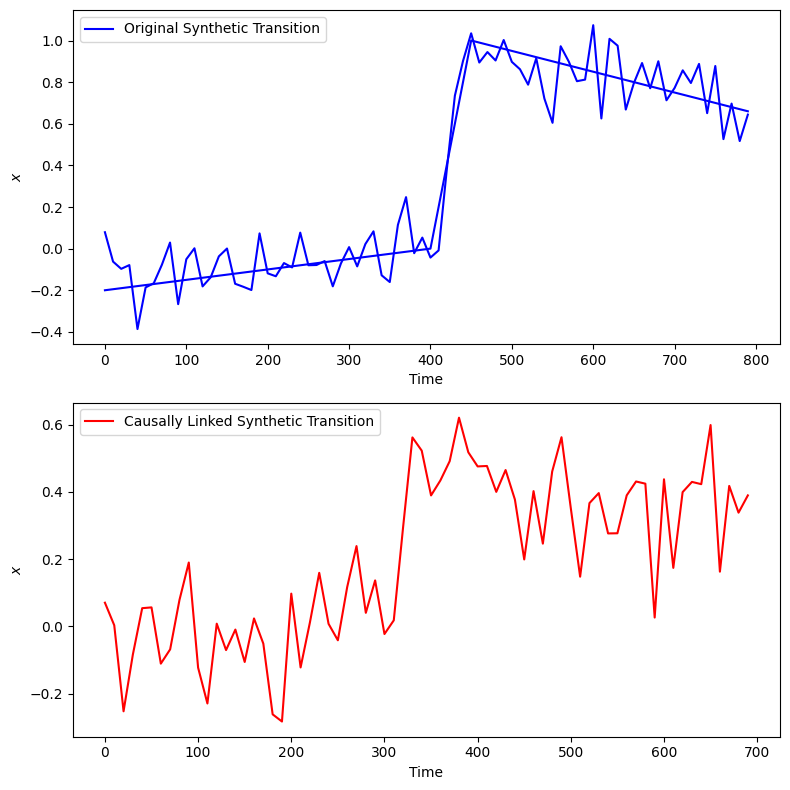

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the functions and parameters as provided by the user
def linear_ramp(t, t0=0.0, dt=1.0, y0=0.0, dy=1.0, GS_slope=0.0, GIS_slope=0.0):
    lt_t0 = t < t0
    gt_t1 = t > t0 + dt
    condlist = [lt_t0, ~np.logical_or(lt_t0, gt_t1), gt_t1]
    funclist = [lambda t: y0 + GS_slope * (t - t0),
                lambda t: y0 + dy * (t - t0) / dt,
                lambda t: y0 + dy + GIS_slope * (t - t0 - dt)]
    y = np.piecewise(t, condlist, funclist)
    return y

def sample_ar1(n, alpha, sigma=1.0, x0=0):
    x = np.zeros(n)
    x[0] = x0 + sigma * np.random.randn()
    sigma_e = np.sqrt(sigma ** 2 * (1 - alpha ** 2))
    for i in range(1, n):
        x[i] = alpha * x[i - 1] + sigma_e * np.random.randn()
    return x

# Parameters for the first synthetic transition
delta = 10.0
t0 = 400.0
dt = 50.0
dy = 1.0
GS_slope = 5e-4
GIS_slope = -1e-3
sigma = 0.1
tau = 1.0
alpha = np.exp(-delta / tau)
time = np.arange(800, step=delta, dtype='float')
trans = linear_ramp(time, t0=t0, dt=dt, y0=0.0, dy=1.0, GS_slope=GS_slope, GIS_slope=GIS_slope)
noise = sample_ar1(len(time), alpha=alpha, sigma=sigma, x0=0)

# Add white noise to the transition
# synt_trans = trans + np.random.normal(0, 0.1, len(time))
synt_trans = trans + noise

# Generate a second dataset that is causally linked to the first
# Introduce a lag for the causal effect
lag = 10  # 10 years lag for the causal effect
# lagged_synt_trans = np.roll(synt_trans, lag)
# # Introduce a lag for the causal effect without wrapping
# lagged_synt_trans = np.full_like(synt_trans, np.nan)  # Initialize an array of NaNs
# lagged_synt_trans[lag:] = synt_trans[:-lag]  # Shift the series without wrapping

# Shift the series 10 units to the left
left_shifted_synt_trans = np.full_like(synt_trans, np.nan)  # Initialize an array of NaNs
left_shifted_synt_trans[:-lag] = synt_trans[lag:]  # Shift the series to the left



# Generate AR(1) noise as the base for the second causally linked dataset
new_noise = sample_ar1(len(time), alpha=alpha, sigma=sigma, x0=0)

# Combine the lagged original series with the new AR(1) series to produce the causally linked series
causal_strength = 0.5  # The strength of the causal link
causally_linked_synt_trans = new_noise + causal_strength * left_shifted_synt_trans
# causally_linked_synt_trans =  causal_strength * lagged_synt_trans

df_gc = pd.DataFrame({
    'A': synt_trans,
    'B': causally_linked_synt_trans
})

# Plot the original and the causally linked datasets
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

# Plot the original synthetic transition
axs[0].plot(time, trans, 'b')
axs[0].plot(time, synt_trans, color='b', label='Original Synthetic Transition')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('$x$')
axs[0].legend()

# Plot the causally linked synthetic transition
axs[1].plot(time, causally_linked_synt_trans, color='r', label='Causally Linked Synthetic Transition')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('$x$')
axs[1].legend()

plt.tight_layout()
plt.show()


# Check stationarity

ADF Statistic: -1.233950772996777
p-value: 0.658823149387882
Critical Values:
	1%: -3.517113604831504
	5%: -2.8993754262546574
	10%: -2.5869547797501644
The series is not stationary.


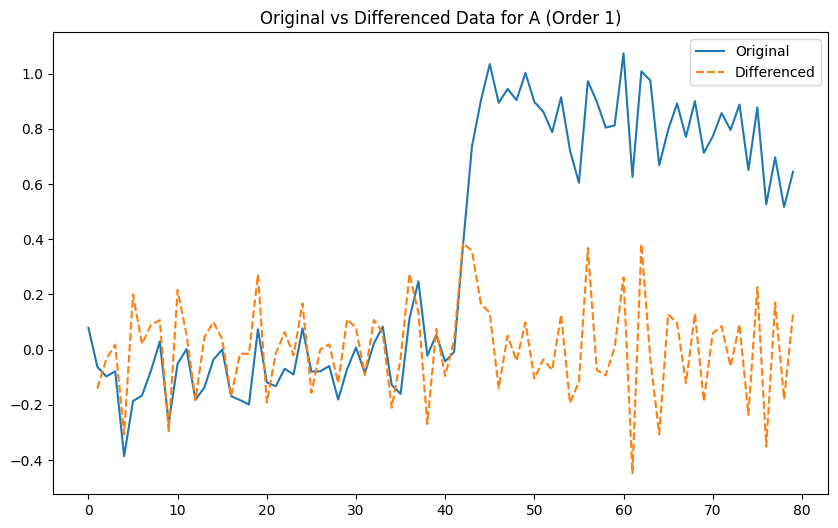

ADF Statistic: -12.627038981309205
p-value: 1.533593839705392e-23
Critical Values:
	1%: -3.517113604831504
	5%: -2.8993754262546574
	10%: -2.5869547797501644
The series is stationary.
Series in column 'A' is stationary after 1 differencing operation(s).
ADF Statistic: -1.8750491356271888
p-value: 0.34388826519823296
Critical Values:
	1%: -3.5319549603840894
	5%: -2.905755128523123
	10%: -2.5903569458676765
The series is not stationary.


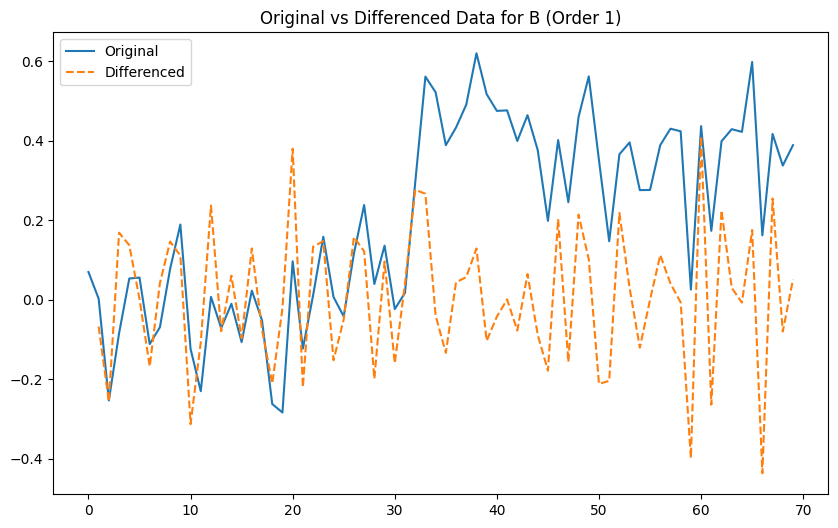

ADF Statistic: -7.857637312258657
p-value: 5.389223918128225e-12
Critical Values:
	1%: -3.5335601309235605
	5%: -2.9064436883991434
	10%: -2.590723948576676
The series is stationary.
Series in column 'B' is stationary after 1 differencing operation(s).
Testing causality between: A and B
Granger Causality Test
------------------------------------------------------------
Direction                   F-statistics         p-value         lag         Granger cause
A => B    3.665               0.002                12                True
B => A    1.152               0.417                19                False

[{'variables': ('A', 'B'), 'XY': True, 'YX': False}]


c:\Users\zps19\.conda\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\zps19\.conda\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


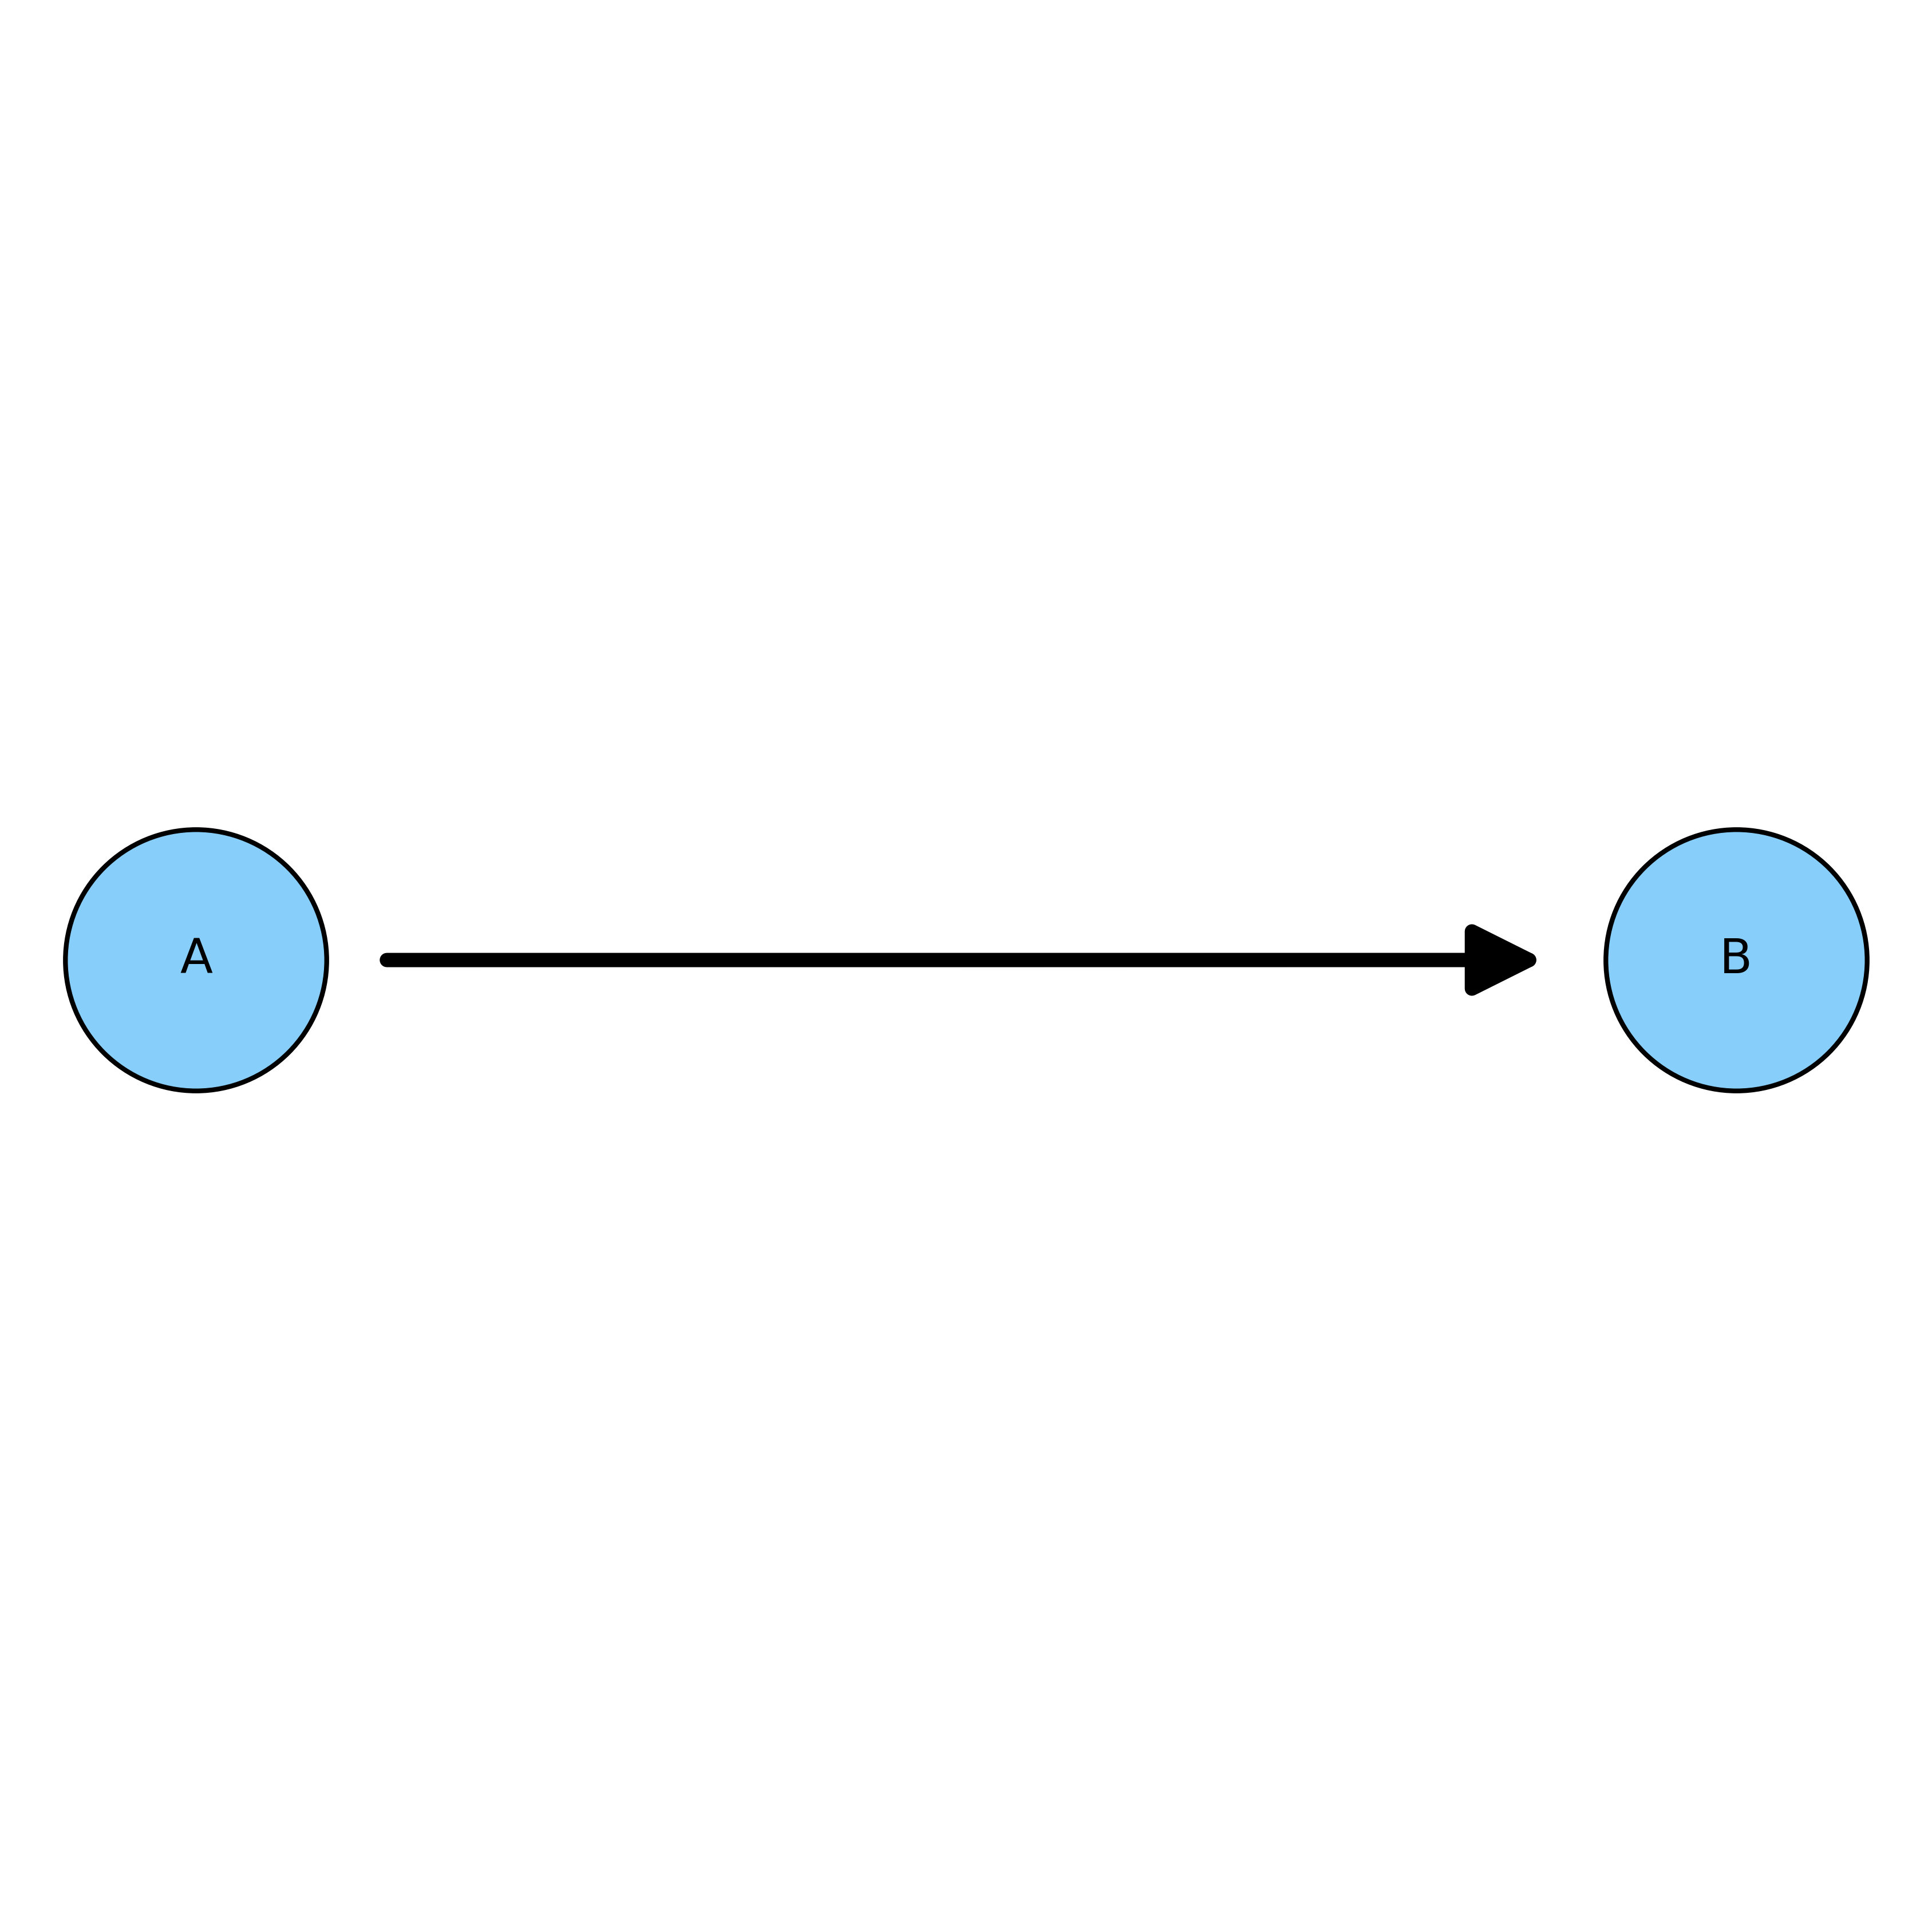

In [13]:
import importlib
from toolbox import GC_functions as GC
importlib.reload(GC)

df_gc_checked=GC.make_stationary(df_gc,['A', 'B'], test_method='ADF',plot=True)

gc_results_A_B = GC.gc4vars(df_gc_checked, max_lags=20)
print(gc_results_A_B)
GC.plot_causal_graph(gc_results_A_B, variables=['B', 'A'])

In [4]:
# smooth df_gc with a rolling window of 10
df_gc_smooth = df_gc.rolling(window=10).mean()
df_gc_smooth = df_gc_smooth.dropna()
df_gc_smooth

,A,B
9,-0.154831,-0.035146
10,-0.136197,-0.036481
11,-0.140626,-0.029193
12,-0.127506,-0.003058
13,-0.117945,0.002367
...,...,...
65,0.806643,0.440413
66,0.815483,0.444453
67,0.792848,0.446317
68,0.795738,0.414364


ADF Statistic: -1.3301644941565394
p-value: 0.6152615510797498
Critical Values:
	1%: -3.5463945337644063
	5%: -2.911939409384601
	10%: -2.5936515282964665
The series is not stationary.


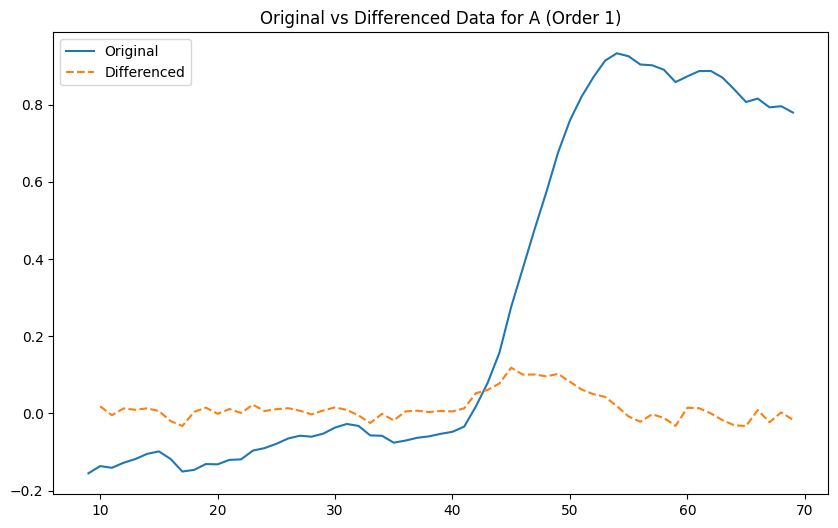

ADF Statistic: -1.9239268369450164
p-value: 0.3208902292626795
Critical Values:
	1%: -3.5463945337644063
	5%: -2.911939409384601
	10%: -2.5936515282964665
The series is not stationary.


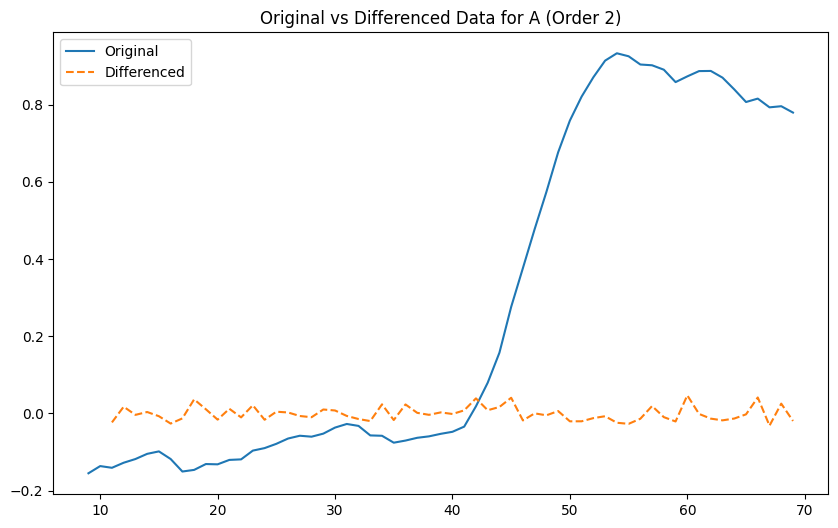

ADF Statistic: -8.729957778382188
p-value: 3.211603149925917e-14
Critical Values:
	1%: -3.548493559596539
	5%: -2.912836594776334
	10%: -2.594129155766944
The series is stationary.
Series in column 'A' is stationary after 2 differencing operation(s).
ADF Statistic: -1.1897289391434946
p-value: 0.6779983833892598
Critical Values:
	1%: -3.5714715250448363
	5%: -2.922629480573571
	10%: -2.5993358475635153
The series is not stationary.


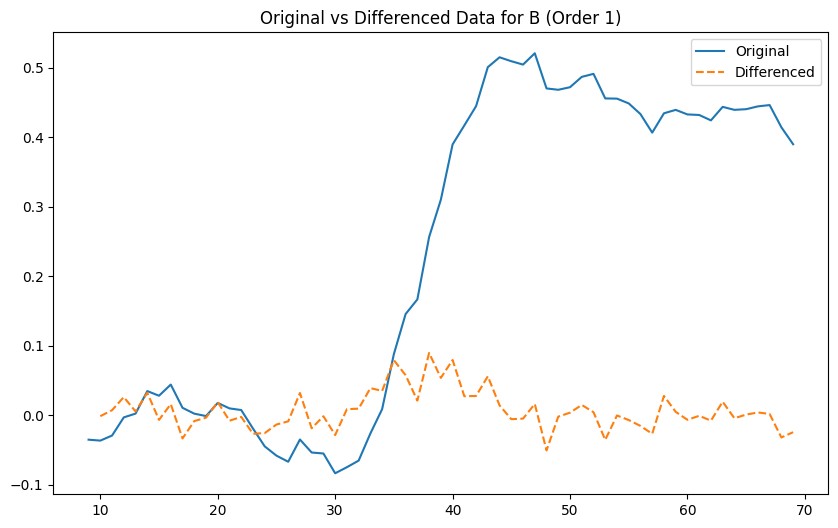

ADF Statistic: -1.8475278831686588
p-value: 0.35713353677252874
Critical Values:
	1%: -3.5714715250448363
	5%: -2.922629480573571
	10%: -2.5993358475635153
The series is not stationary.


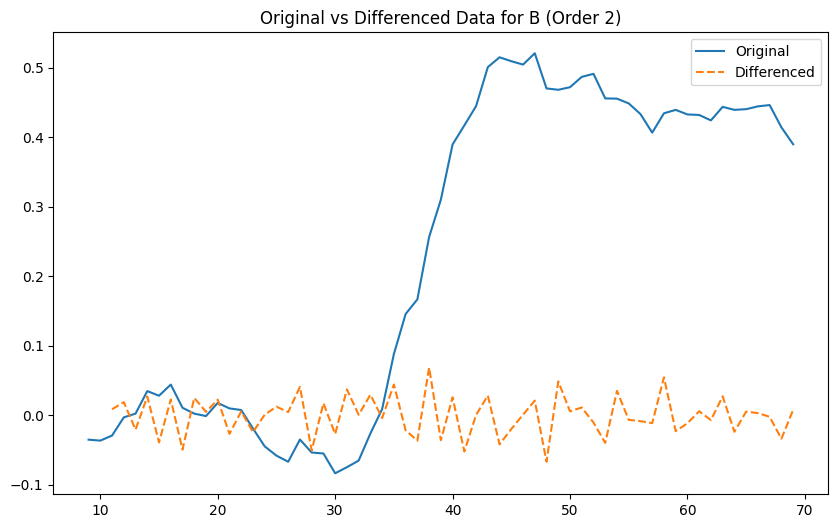

ADF Statistic: -2.972403971752081
p-value: 0.03755312956506651
Critical Values:
	1%: -3.5745892596209488
	5%: -2.9239543084490744
	10%: -2.6000391840277777
The series is stationary.
Series in column 'B' is stationary after 2 differencing operation(s).
Testing causality between: A and B
Granger Causality Test
------------------------------------------------------------
Direction                   F-statistics         p-value         lag         Granger cause
A => B    6.465               0.009                17                True
B => A    3.059               0.037                3                True

[{'variables': ('A', 'B'), 'XY': True, 'YX': True}]


c:\Users\zps19\.conda\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\zps19\.conda\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


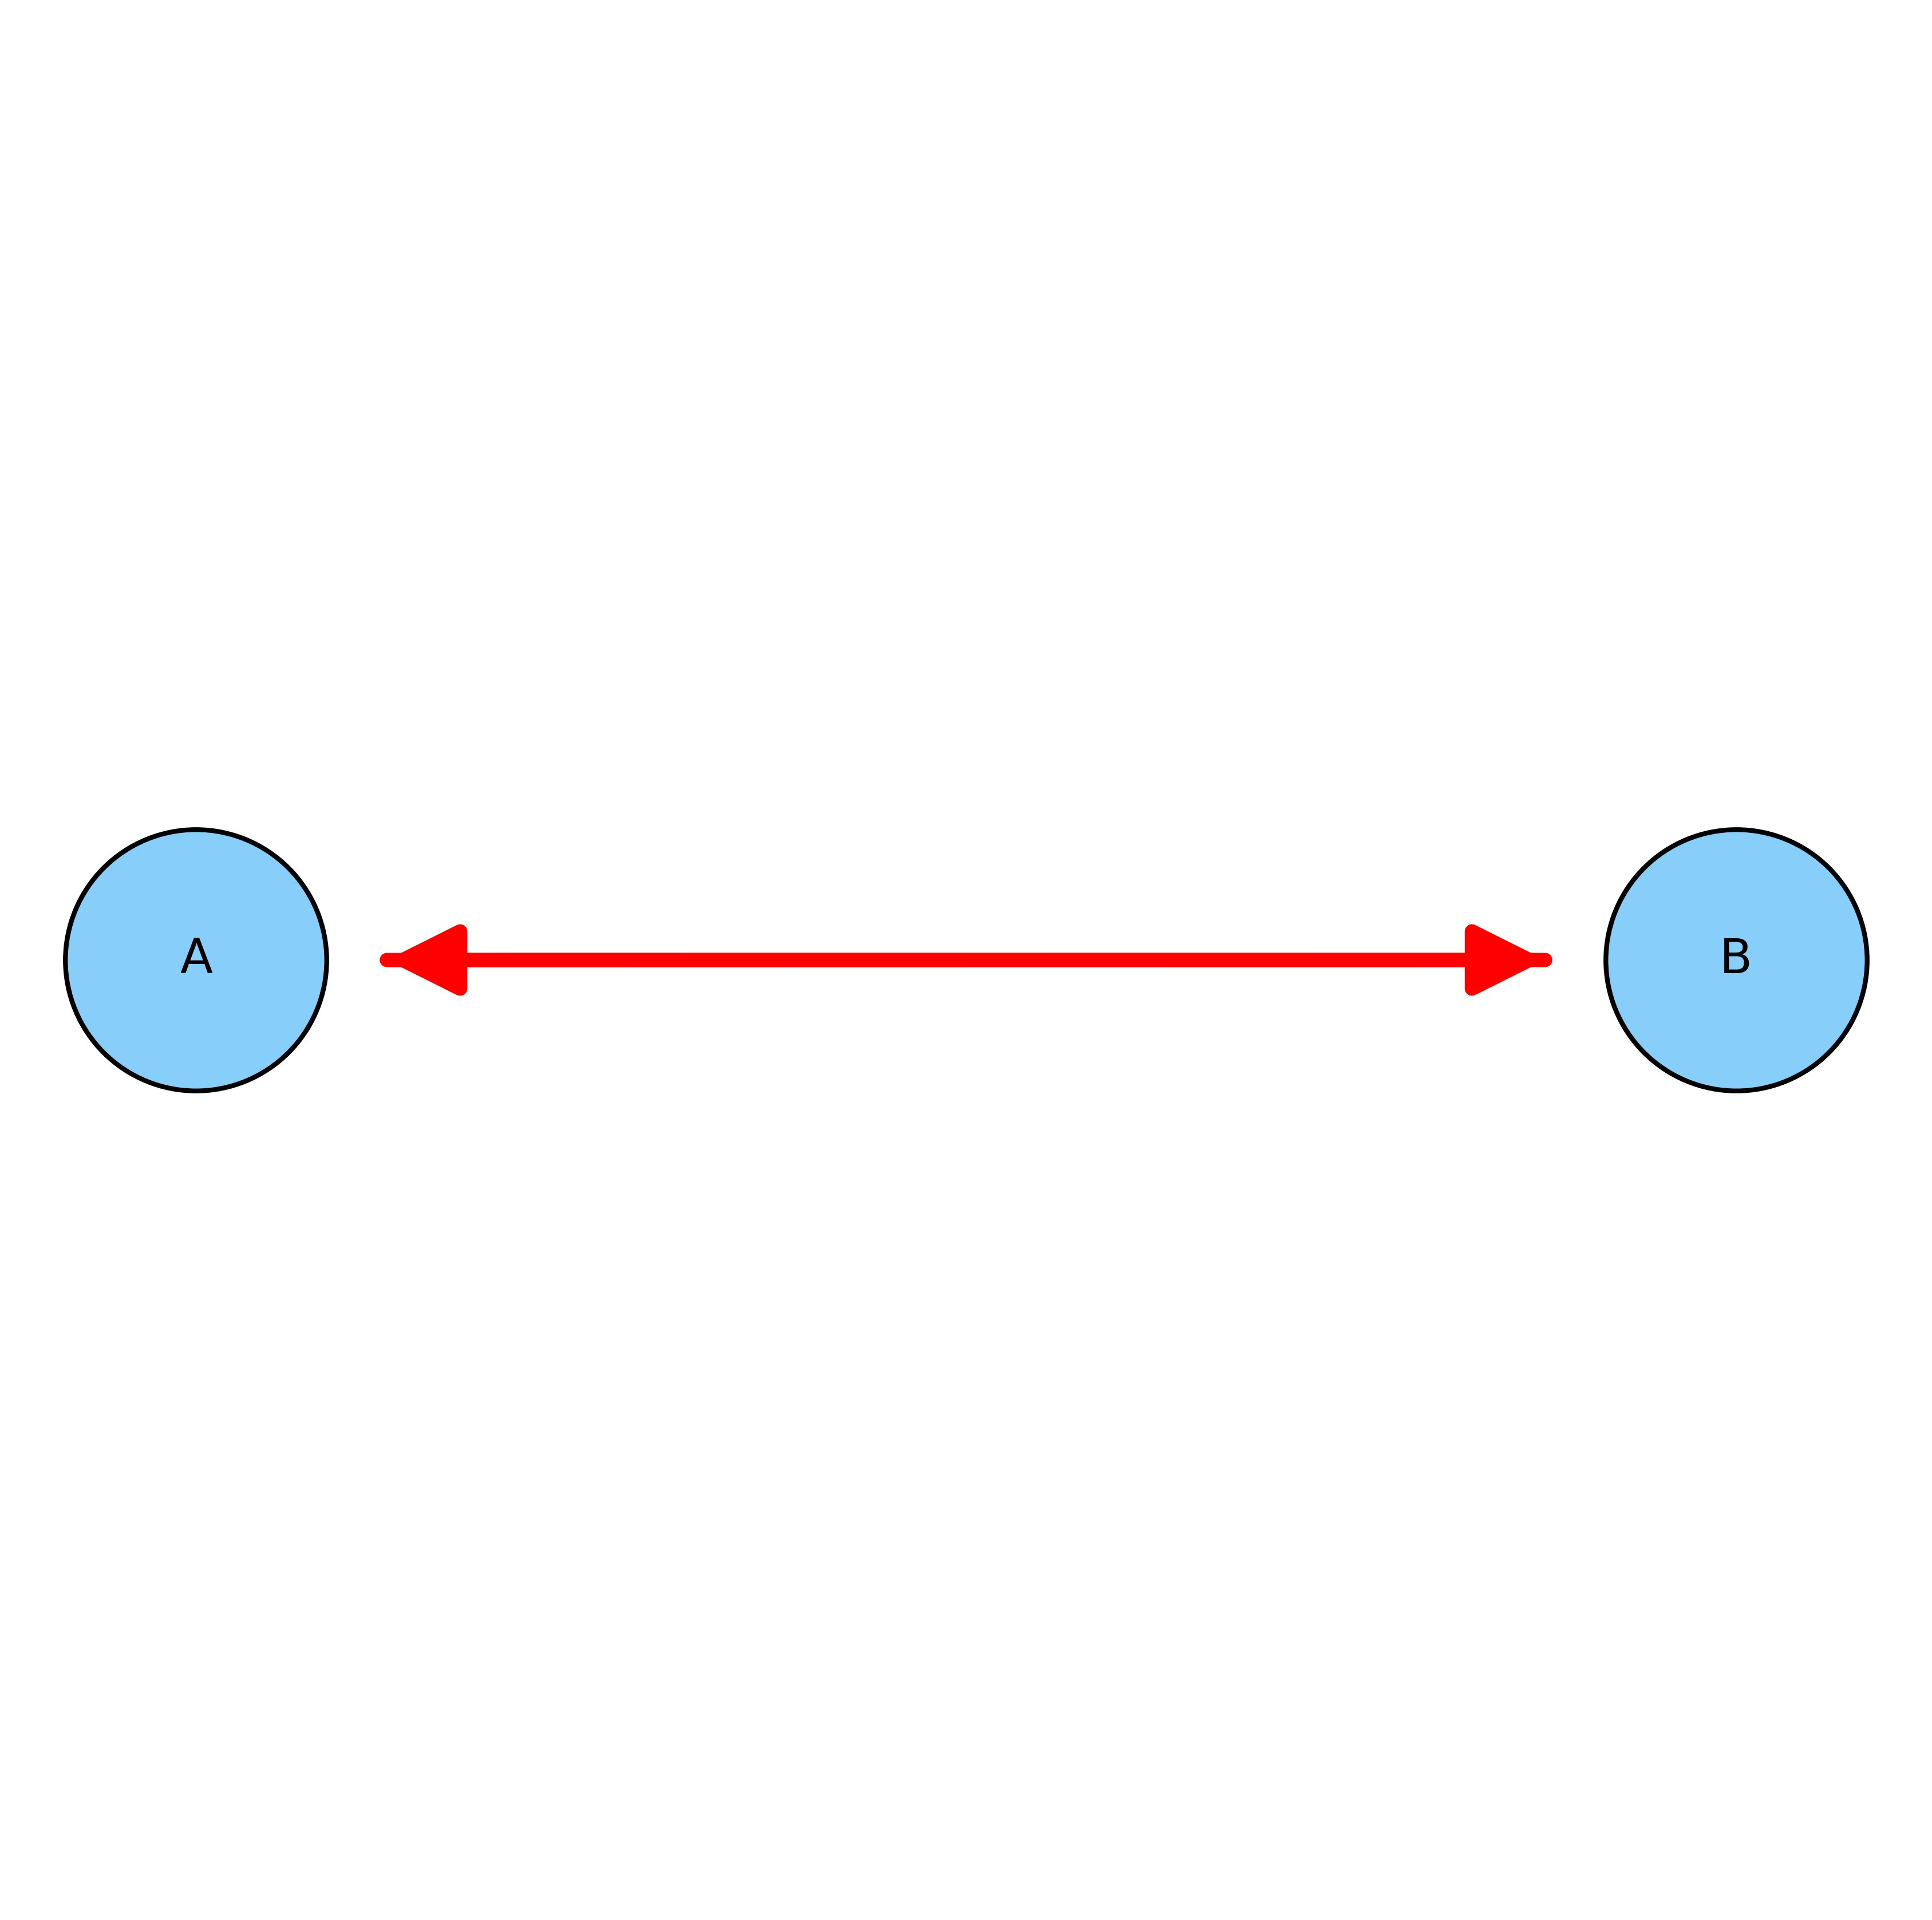

In [6]:
import importlib
from toolbox import GC_functions as GC
importlib.reload(GC)

df_gc_smooth_checked=GC.make_stationary(df_gc_smooth,['A', 'B'], test_method='ADF',plot=True)

gc_results_smoothed_A_B = GC.gc4vars(df_gc_smooth_checked, max_lags=18)
print(gc_results_smoothed_A_B)
GC.plot_causal_graph(gc_results_smoothed_A_B, variables=['B', 'A'])